In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import files
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore')
%matplotlib inline


# Importing libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Importing the missing function

In [2]:
# Import dataset and checking data available

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Load the file into a pandas DataFrame
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
print(f"Uploaded file: {file_name}")

# Load the file into a DataFrame
mpg = pd.read_excel(file_name)

# Step 3: Display the first few rows of the DataFrame
print("\nData Preview:")
print(mpg.head())

Saving mpg.data.xlsx to mpg.data.xlsx
Uploaded file: mpg.data.xlsx

Data Preview:
    mpg  cylinders  displayments  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  Unnamed: 9  Unnamed: 10  \
0          70       1  chevrolet chevelle malibu         NaN          NaN   
1          70       1          buick skylark 320         NaN          NaN   
2          70       1         plymouth satellite         NaN          NaN   
3          70       1              amc rebel sst         NaN          NaN   
4          70       1                ford torino         NaN          NaN   

   Unnamed: 11 Unnamed: 12  
0    

In [ ]:
# Preprocessing steps from D02

In [3]:
# Drop unnecessary columns

mpg = mpg.drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])

In [4]:
# Correctly rename column "displayments"

mpg = mpg.rename(columns={'displayments': 'displacement'})

In [5]:
# Replace the two-digit year into a four-digit year, replace the model year column and drop the new column

mpg['model_year_full'] = mpg['model year'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)
mpg['model year'] = mpg['model_year_full']
mpg.drop('model_year_full', axis=1, inplace=True)

In [6]:
# Drop null values for the column 'mpg' and replace nulls in the 'horsepower' column with median

mpg = mpg.dropna(subset=["mpg"])
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())

pd.isnull(mpg).sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
model year,0
origin,0
car name,0


In [7]:
# Change data type for displacement and horsepower

columns_for_change = ['displacement', 'horsepower']
mpg[columns_for_change] = mpg[columns_for_change].astype(int)

In [8]:
# Split the "car model" column to make two separate columns "brand" and "car name"

mpg[['brand', 'model']] = mpg['car name'].str.split(' ', n=1, expand=True)
mpg['model'] = mpg['model'].str.replace(' ', ' ', regex=False)

In [9]:
# Remove "car name" and "model" columns

mpg.drop('car name', axis=1, inplace=True)
mpg.drop('model', axis=1, inplace=True)

In [10]:
# Correct the mispelled brand names

brand_corrections = {
    "vw": "volkswagen",
    "maxda": "mazda",
    "chevroelt": "chevrolet",
    "chevy": "chevrolet",
    "toyouta": "toyota",
    "mercedes": "mercedes-benz","vokswagen": "volkswagen","capri":"ford","mercury":"ford","triumph":"bmw","plymouth":"chrysler"}
mpg["brand"] = mpg["brand"].replace(brand_corrections)

In [11]:
# Determine the top brands (top 5 by count). One-hot encode the top brands and combine others

top_brands = mpg["brand"].value_counts().nlargest(5).index
mpg_encoded = pd.get_dummies(mpg["brand"].where(mpg["brand"].isin(top_brands), "other"))

In [12]:
# Merge "mpg" and "mpg_endoded" DataFrames and drop "brand" column

mpg = pd.concat([mpg, mpg_encoded], axis=1)
mpg.drop('brand', axis=1, inplace=True)

In [13]:
# New column Efficiency replacing numbers with categories
# (max - min) / 3 -> low (3), medium (2), high (1) fuel efficiency

# Calculate min, max, and range
min_mpg = mpg['mpg'].min()
max_mpg = mpg['mpg'].max()
range_mpg = max_mpg - min_mpg

# Calculate thresholds
thresholds = [min_mpg + range_mpg * i / 3 for i in (1, 2)]

# Define bins and labels
bins = [float('-inf')] + thresholds + [float('inf')]
labels = [3, 2, 1]  # Low (3), Medium (2), High (1)

# Apply classification
mpg['efficiency'] = pd.cut(mpg['mpg'], bins=bins, labels=labels, include_lowest=True)

In [14]:
# Remove "mpg" column

mpg.drop('mpg', axis=1, inplace=True)

mpg.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other,efficiency
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False,3
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True,3
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False,3
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False,3
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False,3


In [15]:
# D03 Model - Evaluate - Predict - Fine Tune
# Logistic Regression - Balanced

In [16]:
# Logistic Regression Preparation

logistic_df = mpg.copy()

In [17]:
# Split the data into features (X) and target (y)
# features: cylinders, displacement, horsepower, weight, acceleration, model year, origin, brands, performance
# target: efficiency

X_logistic = logistic_df.drop(columns=['efficiency'])
y_logistic = logistic_df['efficiency']

In [18]:
X_logistic.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False


In [19]:
y_logistic.head()

,efficiency
0,3
1,3
2,3
3,3
4,3


In [20]:
# Feature scaling

scaler = StandardScaler()
X_logistic_scaled = scaler.fit_transform(X_logistic)

In [21]:
# Split Data in train and test sets

X_logistic_train, X_logistic_test, y_logistic_train, y_logistic_test = train_test_split(X_logistic_scaled, y_logistic, test_size=0.2, random_state=42)

print(f'Training Set Size: {X_logistic_train.shape[0]} samples')
print(f'Test Set Size: {X_logistic_test.shape[0]} samples')

Training Set Size: 318 samples
Test Set Size: 80 samples


In [22]:
# Create Logistic Regression model with class_weight='balanced'

log_reg_model = LogisticRegression(class_weight='balanced')

In [23]:
# Fit the model on training data

log_reg_model.fit(X_logistic_train, y_logistic_train)

LogisticRegression(class_weight='balanced')

In [24]:
# Predict on training data and test data

pred_train = log_reg_model.predict(X_logistic_train)
pred_test = log_reg_model.predict(X_logistic_test)

In [25]:
# Evaluate (Accuracy)

train_accuracy = accuracy_score(y_logistic_train, pred_train)
test_accuracy = accuracy_score(y_logistic_test, pred_test)

print(f"Logistic Regression - Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Logistic Regression - Test Accuracy: {test_accuracy * 100:.2f}%")

Logistic Regression - Train Accuracy: 84.28%
Logistic Regression - Test Accuracy: 88.75%


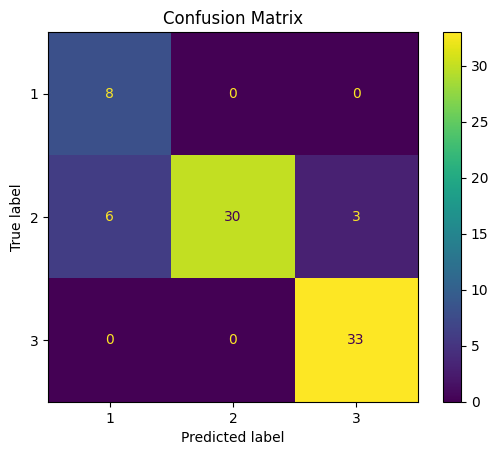

In [26]:
# Confusion Matrix

cm_display = ConfusionMatrixDisplay.from_estimator(log_reg_model, X_logistic_test, y_logistic_test, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Classification Report

print("Classification Report:")
print(classification_report(y_logistic_test, pred_test))

Classification Report:
              precision    recall  f1-score   support

           1       0.57      1.00      0.73         8
           2       1.00      0.77      0.87        39
           3       0.92      1.00      0.96        33

    accuracy                           0.89        80
   macro avg       0.83      0.92      0.85        80
weighted avg       0.92      0.89      0.89        80



In [28]:
#Class 1 shows:

#Precision: 0.57, meaning 57% of predicted class 1 instances were correct.
#Recall: 1.00, indicating all actual class 1 instances were correctly predicted.
#F1-Score: 0.73, balancing both precision and recall.
#Class 2 and 3 perform well with high precision, recall, and F1-scores. Overall, the model achieves good accuracy at 89%.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Δημιουργία Logistic Regression μοντέλου
model = LogisticRegression(max_iter=1000)  # Αυξημένο max_iter για καλύτερη σύγκλιση

# Cross Validation (5-Fold)
cv_scores = cross_val_score(model, X_logistic_train, y_logistic_train, cv=5)

# Εκτύπωση αποτελεσμάτων
print("Cross Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

# Αξιολόγηση του μέσου όρου ακρίβειας
if np.mean(cv_scores) >= 0.90:
    print("Το μοντέλο είναι πολύ καλό, ως προς την αξιολόγηση της ακρίβειας.")
elif 0.70 <= np.mean(cv_scores) < 0.85:
    print("Το μοντέλο μπορεί να βελτιωθεί, ως προς την αξιολόγηση της ακρίβειας.")
elif np.mean(cv_scores) < 0.70:
    print("Το μοντέλο πιθανώς δεν είναι αξιόπιστο, ως προς την αξιολόγηση της ακρίβειας.")

# Αξιολόγηση της διακύμανσης
if 0.01 <= np.std(cv_scores) <= 0.05:
    print("Σταθερό μοντέλο, ως προς την αξιολόγηση της διακύμανσης.")
elif np.std(cv_scores) > 0.1:
    print("Το μοντέλο έχει μεγάλες διακυμάνσεις ανάλογα με τα δεδομένα, ως προς την αξιολόγηση της διακύμανσης.")


Cross Validation Scores: [0.766 0.859 0.844 0.778 0.841]
Mean Accuracy: 0.8175595238095237
Standard Deviation: 0.03814822755213026
Το μοντέλο μπορεί να βελτιωθεί, ως προς την αξιολόγηση της ακρίβειας.
Σταθερό μοντέλο, ως προς την αξιολόγηση της διακύμανσης.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
model = LogisticRegression(max_iter=1000)

# Define hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to use
    'penalty': ['l2', 'l1'],  # Regularization type (L1 or L2)
    'class_weight': [None, 'balanced'],  # Class weighting for imbalance handling
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_logistic_train, y_logistic_train)

# Get the best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator (optimized Logistic Regression model)
best_lr_model = grid_search.best_estimator_

# Predict using the best model
y_pred_best = best_lr_model.predict(X_logistic_test)

# Evaluate the optimized model
from sklearn.metrics import classification_report, accuracy_score
print("Optimized Logistic Regression Accuracy:", accuracy_score(y_logistic_test, y_pred_best))
print(classification_report(y_logistic_test, y_pred_best))


Best Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Optimized Logistic Regression Accuracy: 0.85
              precision    recall  f1-score   support

           1       0.75      0.38      0.50         8
           2       0.83      0.87      0.85        39
           3       0.89      0.94      0.91        33

    accuracy                           0.85        80
   macro avg       0.82      0.73      0.75        80
weighted avg       0.84      0.85      0.84        80

